# Activation Patching the Choose Similar Entity Task

The goal is to find the entity among three who is most similar to a stated comparison entity.



## General Hypothesis

![General Hypothesis](images/choose_sim_ent.png)

So the question is whether a similar mlp and attention pattern exists in this task as exists in the connections task.

## Experimental Design

I will run activation patching.

Here, I will keep the set common, and patch on the subject int.

My goal is to visualize the indirect effects of the residual, mlp, and attention layers.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json

import sys

sys.path.append("../")

##################################################################
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7" #! NOTE: CHANGE TO 0,1 FOR VAST AI
##################################################################

import logging
from src.utils import logging_utils
from src.utils import env_utils

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.DEBUG,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)

import torch
os.environ["TRANSFORMERS_VERBOSITY"] = "error"
import transformers

logger.info(f"{torch.__version__=}, {torch.version.cuda=}")
logger.info(
    f"{torch.cuda.is_available()=}, {torch.cuda.device_count()=}, {torch.cuda.get_device_name()=}"
)
logger.info(f"{transformers.__version__=}")

2025-07-04 07:17:56 __main__ INFO     torch.__version__='2.7.1+cu126', torch.version.cuda='12.6'
2025-07-04 07:17:56 __main__ INFO     torch.cuda.is_available()=True, torch.cuda.device_count()=8, torch.cuda.get_device_name()='NVIDIA A100 80GB PCIe'
2025-07-04 07:17:56 __main__ INFO     transformers.__version__='4.53.0'


In [3]:
from src.utils.training_utils import get_device_map

model_key = "meta-llama/Llama-3.3-70B-Instruct"

device_map = get_device_map(model_key, 30, n_gpus=8) #! NOTE: CHANGE n_gpus=2 FOR VAST AI
device_map

2025-07-04 07:17:59 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/gio/mechinterp, stdin=None, shell=False, universal_newlines=False)
2025-07-04 07:17:59 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/gio/mechinterp, stdin=None, shell=False, universal_newlines=False)


{'model.embed_tokens': 7,
 'model.norm': 7,
 'model.rotary_emb': 7,
 'lm_head': 7,
 'model.layers.0': 0,
 'model.layers.1': 1,
 'model.layers.2': 2,
 'model.layers.3': 3,
 'model.layers.4': 4,
 'model.layers.5': 5,
 'model.layers.6': 6,
 'model.layers.7': 7,
 'model.layers.8': 0,
 'model.layers.9': 1,
 'model.layers.10': 2,
 'model.layers.11': 3,
 'model.layers.12': 4,
 'model.layers.13': 5,
 'model.layers.14': 6,
 'model.layers.15': 7,
 'model.layers.16': 0,
 'model.layers.17': 1,
 'model.layers.18': 2,
 'model.layers.19': 3,
 'model.layers.20': 4,
 'model.layers.21': 5,
 'model.layers.22': 6,
 'model.layers.23': 7,
 'model.layers.24': 0,
 'model.layers.25': 1,
 'model.layers.26': 2,
 'model.layers.27': 3,
 'model.layers.28': 4,
 'model.layers.29': 5,
 'model.layers.30': 0,
 'model.layers.31': 1,
 'model.layers.32': 2,
 'model.layers.33': 3,
 'model.layers.34': 4,
 'model.layers.35': 5,
 'model.layers.36': 6,
 'model.layers.37': 7,
 'model.layers.38': 0,
 'model.layers.39': 1,
 'model

In [4]:
from src.models import ModelandTokenizer
from transformers import BitsAndBytesConfig
import torch

mt = ModelandTokenizer(
    model_key=model_key,
    torch_dtype=torch.bfloat16,
    # device_map=device_map,
    device_map="auto",
    quantization_config = BitsAndBytesConfig(
        load_in_4bit=True
        #load_in_8bit=True
    )
)

2025-07-04 07:18:01 bitsandbytes.cextension DEBUG    Loading bitsandbytes native library from: /disk/u/gio/.conda/envs/retrieval/lib/python3.11/site-packages/bitsandbytes/libbitsandbytes_cuda126.so


Loading checkpoint shards:   0%|          | 0/30 [00:00<?, ?it/s]

2025-07-04 07:18:50 src.models INFO     loaded model <models/meta-llama/Llama-3.3-70B-Instruct> | size: 36650.516 MB | dtype: torch.bfloat16 | device: cuda:0


In [5]:
mt

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 8192)
    (layers): ModuleList(
      (0-79): 80 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=8192, out_features=8192, bias=False)
          (k_proj): Linear4bit(in_features=8192, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=8192, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=8192, out_features=8192, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=8192, out_features=28672, bias=False)
          (up_proj): Linear4bit(in_features=8192, out_features=28672, bias=False)
          (down_proj): Linear4bit(in_features=28672, out_features=8192, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((8192,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((8192,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((819

In [8]:
from src.functional import generate_with_patch
#from src.evaluation import get_choice

subject_int = "Isaac Newton"
subject_set = ["Brad Pitt", "Albert Einstein", "Michael Jordan"]

common_entities = ["Brad Pitt", "Albert Einstein", "Michael Jordan"]
clean_entity = "Isaac Newton"
patched_entity = "Kobe Bryant"
#clean_answer = 


test_prompt = f"""Q:Which of the following people has something in common with {subject_int}? {(", ").join(subject_set)}.
A:"""
print(test_prompt)
# test_prompt += " Yes -"

generate_with_patch(
    mt=mt,
    inputs=test_prompt,
    n_gen_per_prompt=1,
    do_sample=False,
    patches=[],
    patch_strategy="replace",
    remove_prefix=True,
    patch_at_all_generations=False,  # don't need to
    # patch_at_all_generations=True,    # will give the same result
)[0]

#get_choice(
#    mt=mt,
#    clean_entity=clean_entity,
#    common_entities=common_entities,
#    prompt_template=prompt_template
#)

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Q:Which of the following people has something in common with Isaac Newton? Brad Pitt, Albert Einstein, Michael Jordan.
A:


' Albert Einstein. Both Einstein and Newton are famous physicists. Newton is known for his work on the laws'

In [9]:
from src.utils.experiment_utils import set_seed
from src.evaluation import get_connection_on_entity_pair, get_choice

SyntaxError: expected ':' (prompt.py, line 38)

In [ ]:
#from src.utils.metrics import recall
from src.utils.experiment_utils import set_seed
from src.evaluation import get_connection_on_entity_pair, get_choice


limit = 1000

results = {}

# Loop through the attributes of interest
for attr in attr_to_names.keys():
    logger.info("-"* 10 + f" {attr} " + "-" * 10)
    targets = [] # To hold the target prediction
    predictions = [] # To hold the actual predictions
    counter = 0 # To count how many samples we've seen
    attr_results = [] # To hold the result for each attribute

    # Loop through pairs of targets and entitites
    ## Will change to (target, (clean, common))
    for target, entities in attr_to_names[attr].items():

        # Creates a list like [(Mohammad Aziz, Fatima Sheikh), (Fatima Sheikh, Mohammad Aziz)]
        for query_entities in [(entities[0], entities[1]), (entities[1], entities[0])]:
        
            set_seed(142) #* for reproducibility

            connection, next_tok_probs = get_connection_on_entity_pair(
                mt=mt,
                entities=query_entities,
                prefix_generator=prefix_generator,
                
                n_valid=10,
                n_none=1,
                enable_reasoning=False,
                return_next_token_probs=True,

                # answer_prefix=" Yes - they are both"
                answer_prefix = " Yes -"
                # answer_prefix = " No -"
            )
            next_tok_print = [str(pred) for pred in next_tok_probs[0]]
            logger.debug(f"{query_entities} => {target} | {next_tok_print}")

            attr_results.append({a
                "query_entities": query_entities,
                "target": target,
                "connection": connection,
                "next_tok_probs": next_tok_probs[0],
            })
        
            targets.append(target)
            predictions.append([pred.token for pred in next_tok_probs[0]])

            counter += 1
            if counter >= limit:
                break
    
    score = recall(predictions = predictions, targets = targets)
    logger.debug('-' * 50)
    logger.info(f"{attr} => recall@k = {score[:5]}")
    logger.debug('-' * 50)

    results[attr] = {
        "attribute": attr,
        "score": score,
        "results": attr_results,
    }

In [10]:
common_entities = ["Brad Pitt", "Albert Einstein", "Michael Jordan"]
clean_entity = "Isaac Newton"
patched_entity = "Kobe Bryant"
connection = "Albert Einstein"
#next_tok_probs  =

SyntaxError: invalid syntax (2690609138.py, line 5)

## Core Flow

1. `align_patching_positions` builds two token sequences:
    - clean_prompt
    - patched_prompt
2. A forward pass on the patched prompt collects all hidden states of the chosen kind

In [6]:
##########################################################
exclude_k = 5
target_attribute = "profession"
#target_attribute = "nationality"
connection_mt = mt
##########################################################

patching_samples = [] # To hold the samples we'll patch on

# Loop through objects containing the entities, target, prediction, and next token probs
for pair_result in results[target_attribute]["results"]:
    # Extract dict objects
    query_entities = pair_result["query_entities"]
    target = pair_result["target"]
    connection = pair_result["connection"]
    next_tok_probs = pair_result["next_tok_probs"]

    # The token of the top predicted answer
    patched_answer = next_tok_probs[0].token

    # Checking if the top prediction is correctly the target
    correct = is_accurate(top_prediction=patched_answer, target=target)
    if correct == False:
        continue

    logger.debug("-" * 150)
    logger.debug(
        f"{query_entities} => {target} | {patched_answer} | {connection}"
    )

    common_entity = query_entities[1]
    patched_entity = query_entities[0]
    clean_entity = None

    # Create the Prompt object
    connection_prompt = prepare_probing_input(
        mt=connection_mt,
        entities=(patched_entity, common_entity),
        prefix=prefix,
        answer_marker=prefix_generator.answer_marker,
        question_marker=prefix_generator.question_marker,
        block_separator=prefix_generator.block_separator,
        is_a_reasoning_model=False,
        answer_prefix = " Yes -"
    )

    prompt_template = connection_prompt.prompt.replace(patched_entity, "{}")

    # searching for the clean entity that gives a different prediction (we don't care about if the prediction is correct or not)
    logger.debug(f"Searching for clean entity. Ans CANNOT be \"{patched_answer}\".")
    clean_candidates = get_clean_candidates(
        entity=common_entity, exclude_entities=[patched_entity]
    )

    for candidate in clean_candidates:
        cur_prompt = prompt_template.format(candidate)
        next_probs = predict_next_token(mt = connection_mt, inputs = cur_prompt)
        next_tok_print = [str(pred) for pred in next_probs[0][:exclude_k]]
        predictions = [pred.token for pred in next_probs[0][:exclude_k]]
        
        can_take_candidate = take_candidate(
            top_predictions=predictions,
            exclude=[patched_answer]
        )

        logger.debug(f"({get_tick_marker(can_take_candidate)}){(candidate, common_entity)} => {next_tok_print}")

        if can_take_candidate:
            logger.debug(f"Found clean entity: {candidate}")
            clean_entity = candidate
            break
    
    if clean_entity is None:
        logger.error(f"Could not find a clean entity for {common_entity} and {patched_entity} -- skipping")

    # Create an activation patching sample
    patching_samples.append(ActivationPatchingSamples(
        prompt_template=prompt_template,
        common_entity=common_entity,
        clean_entity=clean_entity,
        patched_entity=patched_entity,
        clean_answer=next_probs[0][0].token if clean_entity else None,
        patched_answer=patched_answer,
        patched_answer_toks = [next_tok_probs[0].token_id]
    ))

    
    logger.debug("-" * 150)

NameError: name 'results' is not defined

In [37]:
from src.dataset import ActivationPatchingChoiceSamples

common_entities = ["Brad Pitt", "Albert Einstein", "Michael Jordan"]
clean_entity = "Isaac Newton"
patched_entity = "Kobe Bryant"
connection = "Albert Einstein"
clean_answer = "Albert Einstein"
patched_answer = " Michael Jordan"

prompt_template = """Q:Which of the following people has something in common with {}? Brad Pitt, Albert Einstein, Michael Jordan.
A:"""

patching_samples = []

patching_samples.append(ActivationPatchingChoiceSamples(
    prompt_template=prompt_template,
    common_entities=common_entities,
    clean_entity=clean_entity,
    patched_entity=patched_entity,
    clean_answer=clean_answer,
    patched_answer=patched_answer,
    patched_answer_toks=mt.tokenizer.encode(patched_answer, add_special_tokens=False),
    )
)

patching_samples

[ActivationPatchingChoiceSamples(prompt_template='Q:Which of the following people has something in common with {}? Brad Pitt, Albert Einstein, Michael Jordan.\nA:', common_entities=['Brad Pitt', 'Albert Einstein', 'Michael Jordan'], clean_entity='Isaac Newton', patched_entity='Kobe Bryant', clean_answer='Albert Einstein', patched_answer=' Michael Jordan', patched_answer_toks=[8096, 17527])]

In [38]:
sample = patching_samples[0]
sample

ActivationPatchingChoiceSamples(prompt_template='Q:Which of the following people has something in common with {}? Brad Pitt, Albert Einstein, Michael Jordan.\nA:', common_entities=['Brad Pitt', 'Albert Einstein', 'Michael Jordan'], clean_entity='Isaac Newton', patched_entity='Kobe Bryant', clean_answer='Albert Einstein', patched_answer=' Michael Jordan', patched_answer_toks=[8096, 17527])

In [39]:
from src.tokens import find_token_range

def align_patching_positions(
    mt,
    prompt_template,
    clean_subj,
    patched_subj,
    clean_input,
    patched_input,
    trace_start_marker,
):
    clean_subj_range = find_token_range(
        string=prompt_template.format(clean_subj),
        substring=clean_subj,
        tokenizer=mt.tokenizer,
        occurrence=-1
    )
    print(f"{clean_subj_range=}")

    patched_subj_range = find_token_range(
        string=prompt_template.format(patched_subj),
        substring=patched_subj,
        tokenizer=mt.tokenizer,
        occurrence=-1
    )
    print(f"{patched_subj_range=}")
    

def trace_important_states(
    mt,
    prompt_template,
    clean_subj,
    patched_subj,
    clean_input = None,
    patched_input = None,
    kind = 'residual',
    window_size = 1,
    normalize = True,
    trace_start_marker = None,
    metric = "logit",
    ans_tokens = None,
):
    aligned = align_patching_positions(
        mt=mt,
        prompt_template=prompt_template,
        clean_subj="Isaac Newton",
        patched_subj="Kobe Bryant",
        clean_input=clean_input,
        patched_input=patched_input,
        trace_start_marker=trace_start_marker,
    )
    print(f"{aligned=}")

clean_subj_range=(13, 15)
(13, 15)
trace_start_idx=2
Decoded clean input: <|begin_of_text|>Q:Which of the following people has something in common with Isaac Newton? Brad Pitt, Albert Einstein, Michael Jordan.
A:
Decoded patched input: <|begin_of_text|>Q:Which of the following people has something in common with Kobe Bryant? Brad Pitt, Albert Einstein, Michael Jordan.
A:
===> trace_start_idx=2
2025-07-04 07:51:02 src.trace DEBUG    tracing answer for ['8096( Michael)', '17527( Jordan)']
2025-07-04 07:51:04 src.trace DEBUG    base_score=13.0 | base_indv_scores={8096: 17.5, 17527: 8.5625}
2025-07-04 07:51:05 src.trace DEBUG    low_score=10.6875 | low_indv_scores={8096: 15.25, 17527: 6.15625}
2025-07-04 07:51:05 src.trace DEBUG    base_score=13.0 | low_score=10.6875
2025-07-04 07:51:05 src.trace DEBUG    ---------- tracing important states | kind='residual' ----------


100%|██████████| 2000/2000 [41:30<00:00,  1.25s/it]

2025-07-04 08:32:36 src.trace INFO     base_score=13.0 | low_score=10.6875
2025-07-04 08:32:36 __main__ INFO     trace_results=CausalTracingResult(patch_input_toks=['<|begin_of_text|>', 'Q', ':', 'Which', ' of', ' the', ' following', ' people', ' has', ' something', ' in', ' common', ' with', ' Kobe', ' Bryant', '?', ' Brad', ' Pitt', ',', ' Albert', ' Einstein', ',', ' Michael', ' Jordan', '.\n', 'A', ':'], corrupt_input_toks=['<|begin_of_text|>', 'Q', ':', 'Which', ' of', ' the', ' following', ' people', ' has', ' something', ' in', ' common', ' with', ' Isaac', ' Newton', '?', ' Brad', ' Pitt', ',', ' Albert', ' Einstein', ',', ' Michael', ' Jordan', '.\n', 'A', ':'], trace_start_idx=2, answer=[PredictedToken(token=' Michael', prob=None, logit=17.5, token_id=8096, metadata=None), PredictedToken(token=' Jordan', prob=None, logit=8.5625, token_id=17527, metadata=None)], low_score=10.6875, base_score=13.0, indirect_effects=tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],

2025-07-04 08:32:36 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/usr/share/texmf/fonts/opentype/public/lm/lmromancaps10-regular.otf', name='Latin Modern Roman Caps', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2025-07-04 08:32:36 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/usr/share/fonts/truetype/adf/GilliusADFNo2-BoldItalic.otf', name='Gillius ADF No2', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
2025-07-04 08:32:36 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/usr/share/texmf/fonts/opentype/public/tex-gyre/texgyrechorus-mediumitalic.otf', name='TeX Gyre Chorus', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
2025-07-04 08:32:36 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/Garuda-Bold.ttf', name='Garuda', style='normal', variant='nor

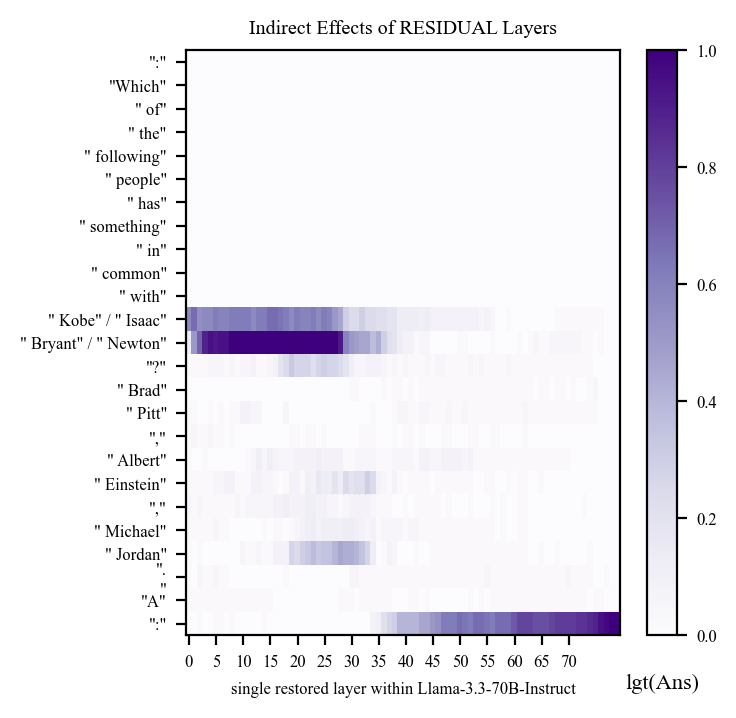

clean_subj_range=(13, 15)
(13, 15)
trace_start_idx=2
Decoded clean input: <|begin_of_text|>Q:Which of the following people has something in common with Isaac Newton? Brad Pitt, Albert Einstein, Michael Jordan.
A:
Decoded patched input: <|begin_of_text|>Q:Which of the following people has something in common with Kobe Bryant? Brad Pitt, Albert Einstein, Michael Jordan.
A:
===> trace_start_idx=2
2025-07-04 08:32:38 src.trace DEBUG    tracing answer for ['8096( Michael)', '17527( Jordan)']
2025-07-04 08:32:40 src.trace DEBUG    base_score=13.0 | base_indv_scores={8096: 17.5, 17527: 8.5625}
2025-07-04 08:32:41 src.trace DEBUG    low_score=10.6875 | low_indv_scores={8096: 15.25, 17527: 6.15625}
2025-07-04 08:32:41 src.trace DEBUG    base_score=13.0 | low_score=10.6875
2025-07-04 08:32:41 src.trace DEBUG    ---------- tracing important states | kind='attention' ----------


100%|██████████| 2000/2000 [41:31<00:00,  1.25s/it]

2025-07-04 09:14:12 src.trace INFO     base_score=13.0 | low_score=10.6875
2025-07-04 09:14:12 __main__ INFO     trace_results=CausalTracingResult(patch_input_toks=['<|begin_of_text|>', 'Q', ':', 'Which', ' of', ' the', ' following', ' people', ' has', ' something', ' in', ' common', ' with', ' Kobe', ' Bryant', '?', ' Brad', ' Pitt', ',', ' Albert', ' Einstein', ',', ' Michael', ' Jordan', '.\n', 'A', ':'], corrupt_input_toks=['<|begin_of_text|>', 'Q', ':', 'Which', ' of', ' the', ' following', ' people', ' has', ' something', ' in', ' common', ' with', ' Isaac', ' Newton', '?', ' Brad', ' Pitt', ',', ' Albert', ' Einstein', ',', ' Michael', ' Jordan', '.\n', 'A', ':'], trace_start_idx=2, answer=[PredictedToken(token=' Michael', prob=None, logit=17.5, token_id=8096, metadata=None), PredictedToken(token=' Jordan', prob=None, logit=8.5625, token_id=17527, metadata=None)], low_score=10.6875, base_score=13.0, indirect_effects=tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],

2025-07-04 09:14:13 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


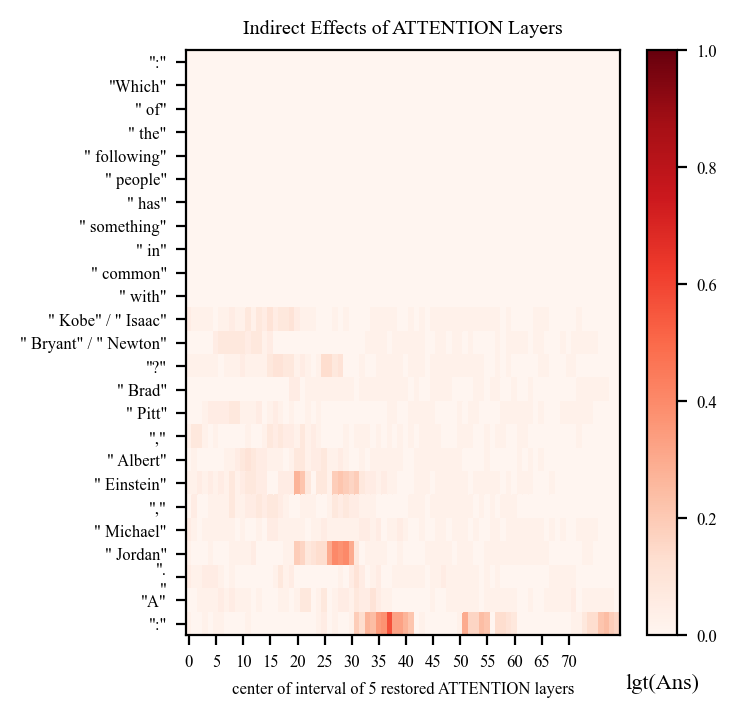

clean_subj_range=(13, 15)
(13, 15)
trace_start_idx=2
Decoded clean input: <|begin_of_text|>Q:Which of the following people has something in common with Isaac Newton? Brad Pitt, Albert Einstein, Michael Jordan.
A:
Decoded patched input: <|begin_of_text|>Q:Which of the following people has something in common with Kobe Bryant? Brad Pitt, Albert Einstein, Michael Jordan.
A:
===> trace_start_idx=2
2025-07-04 09:14:13 src.trace DEBUG    tracing answer for ['8096( Michael)', '17527( Jordan)']
2025-07-04 09:14:15 src.trace DEBUG    base_score=13.0 | base_indv_scores={8096: 17.5, 17527: 8.5625}
2025-07-04 09:14:17 src.trace DEBUG    low_score=10.6875 | low_indv_scores={8096: 15.25, 17527: 6.15625}
2025-07-04 09:14:17 src.trace DEBUG    base_score=13.0 | low_score=10.6875
2025-07-04 09:14:17 src.trace DEBUG    ---------- tracing important states | kind='mlp' ----------


100%|██████████| 2000/2000 [41:31<00:00,  1.25s/it]

2025-07-04 09:55:49 src.trace INFO     base_score=13.0 | low_score=10.6875
2025-07-04 09:55:49 __main__ INFO     trace_results=CausalTracingResult(patch_input_toks=['<|begin_of_text|>', 'Q', ':', 'Which', ' of', ' the', ' following', ' people', ' has', ' something', ' in', ' common', ' with', ' Kobe', ' Bryant', '?', ' Brad', ' Pitt', ',', ' Albert', ' Einstein', ',', ' Michael', ' Jordan', '.\n', 'A', ':'], corrupt_input_toks=['<|begin_of_text|>', 'Q', ':', 'Which', ' of', ' the', ' following', ' people', ' has', ' something', ' in', ' common', ' with', ' Isaac', ' Newton', '?', ' Brad', ' Pitt', ',', ' Albert', ' Einstein', ',', ' Michael', ' Jordan', '.\n', 'A', ':'], trace_start_idx=2, answer=[PredictedToken(token=' Michael', prob=None, logit=17.5, token_id=8096, metadata=None), PredictedToken(token=' Jordan', prob=None, logit=8.5625, token_id=17527, metadata=None)], low_score=10.6875, base_score=13.0, indirect_effects=tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],

2025-07-04 09:55:49 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


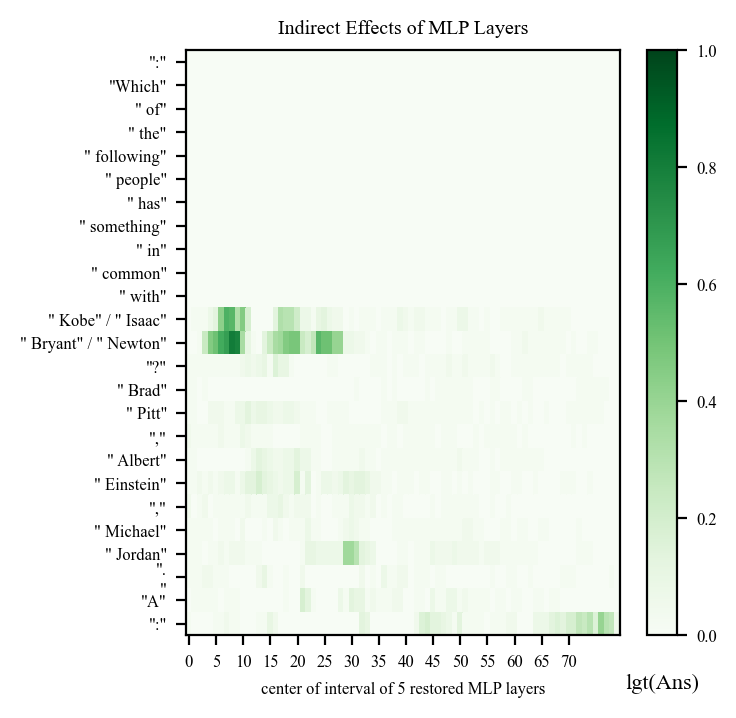

In [41]:
from src.trace import trace_important_states
from src.plotting import plot_trace_heatmap

for kind in ["residual", "attention", "mlp"]:
    trace_results = trace_important_states(
        mt=mt,
        prompt_template=sample.prompt_template,
        clean_subj=sample.clean_entity,
        patched_subj=sample.patched_entity,
        trace_start_marker="Q:",
        metric="logit",
        kind=kind,
        window_size=1 if kind == "residual" else 5,
        ans_tokens=sample.patched_answer_toks,
    )

    logger.info(f"{trace_results=}")

    plot_trace_heatmap(
        result=trace_results,
        model_name=model_key.split("/")[-1],
        scale_range=(0, 1) if trace_results.normalized is True else None,
    )

In [ ]:
from src.dataset import ActivationPatchingChoiceSamples

common_entities = ["Brad Pitt", "Albert Einstein", "Michael Jordan"]
clean_entity = "Isaac Newton"
patched_entity = "Kobe Bryant"
connection = "Albert Einstein"
clean_answer = "Albert Einstein"
patched_answer = " Michael Jordan"

prompt_template = f"""Q:Which of the following people has something in common with {subject_int}? {(", ").join(subject_set)}.
A:"""

patching_samples = []

patching_samples.append(ActivationPatchingChoiceSamples(
    prompt_template=prompt_template,
    common_entities=common_entities,
    clean_entity=clean_entity,
    patched_entity=connection,
    clean_answer=clean_answer,
    patched_answer=patched_answer,
    patched_answer_toks=mt.tokenizer.encode(patched_answer, add_special_tokens=False),
    )
)

patching_samples

[ActivationPatchingChoiceSamples(prompt_template='Q:Which of the following people has something in common with Isaac Newton? Brad Pitt, Albert Einstein, Michael Jordan.\nA:', common_entities=['Brad Pitt', 'Albert Einstein', 'Michael Jordan'], clean_entity='Isaac Newton', patched_entity='Albert Einstein', clean_answer='Albert Einstein', patched_answer=' Michael Jordan', patched_answer_toks=[8096, 17527])]